In [1]:
! wget http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz

--2017-01-28 18:17:49--  http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘WISDM_ar_latest.tar.gz’

100%[======================================>] 11,404,612  5.14MB/s   in 2.1s   

2017-01-28 18:17:51 (5.14 MB/s) - ‘WISDM_ar_latest.tar.gz’ saved [11404612/11404612]



In [2]:
!tar -xvzf WISDM_ar_latest.tar.gz

WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [3]:
from tqdm import *

In [4]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [14]:
dataset = read_data('./WISDM/actitracker_raw.txt')

In [15]:
dataset.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [17]:
dataz = dataset['z-axis'].astype('str')
z_data = []
for i in tqdm(range(len(dataset))):
   z_data.append(dataz[i].replace(';',''))
#dataz[0].replace(';','')

100%|██████████| 1098204/1098204 [00:46<00:00, 23537.62it/s]


In [18]:
z_data = [float(i) for i in z_data]

In [19]:
dataset['z-axis'] = z_data

In [20]:
dataset.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [22]:
dataset.dtypes

user-id        int64
activity      object
timestamp      int64
x-axis       float64
y-axis       float64
z-axis       float64
dtype: object

In [25]:
dataset.dropna(inplace=True)

In [26]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])

In [27]:
dataset['y-axis'] = feature_normalize(dataset['y-axis'])

In [29]:
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

In [30]:
dataset.shape

(1098203, 6)

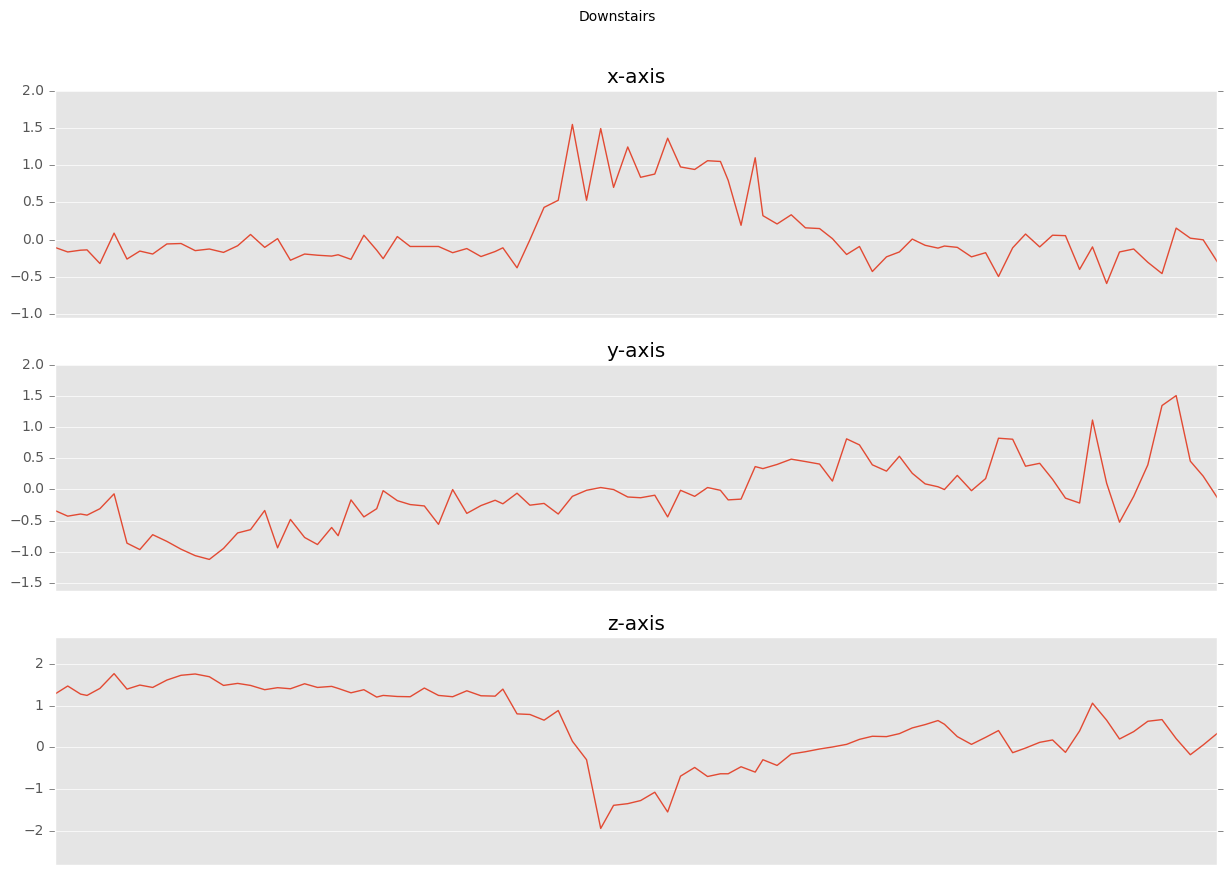

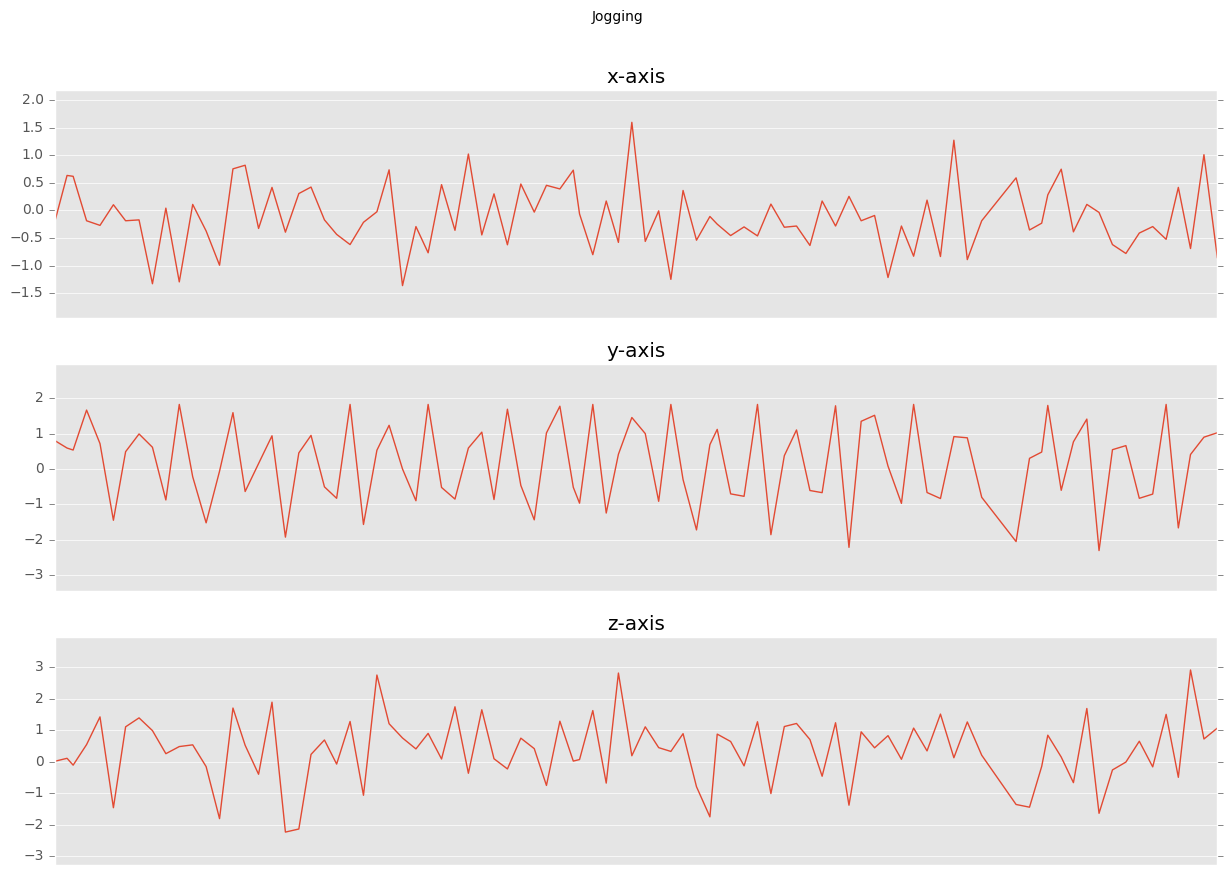

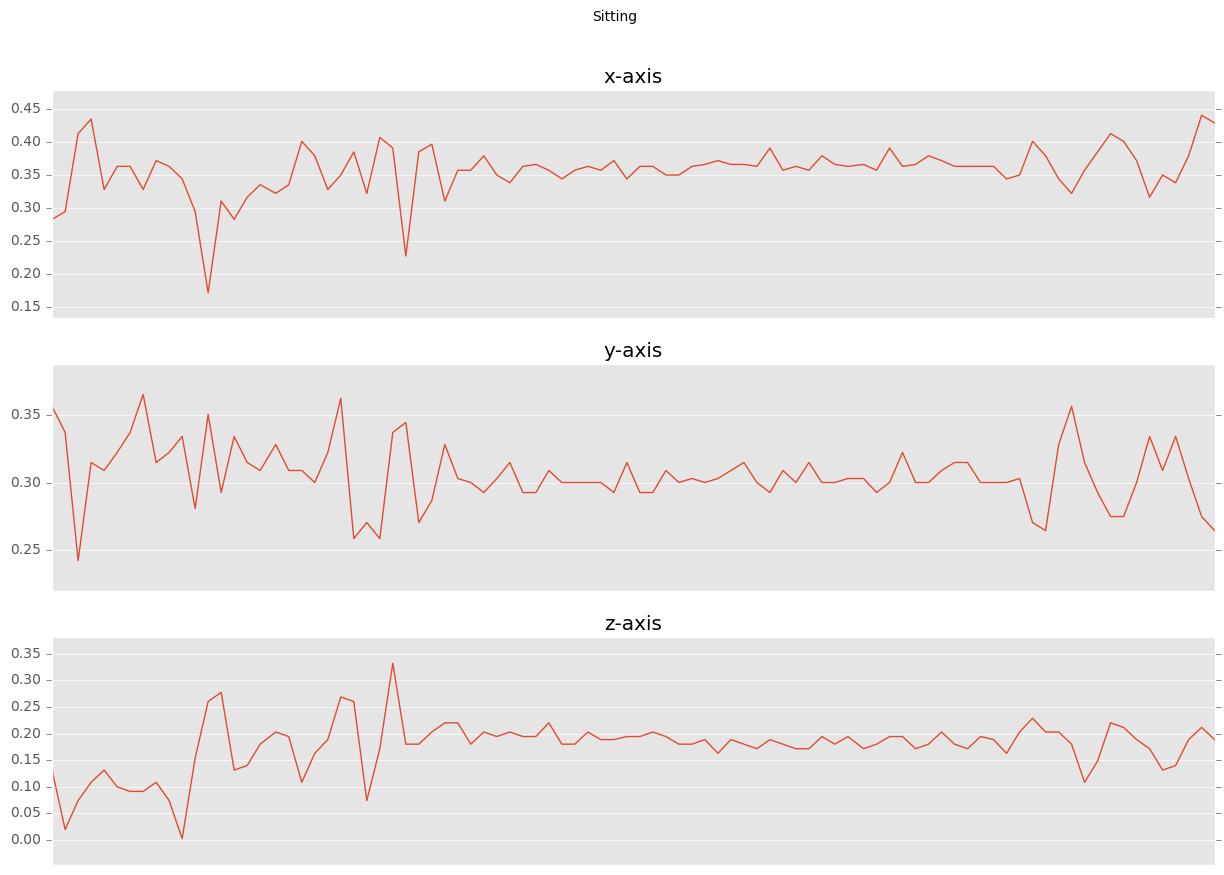

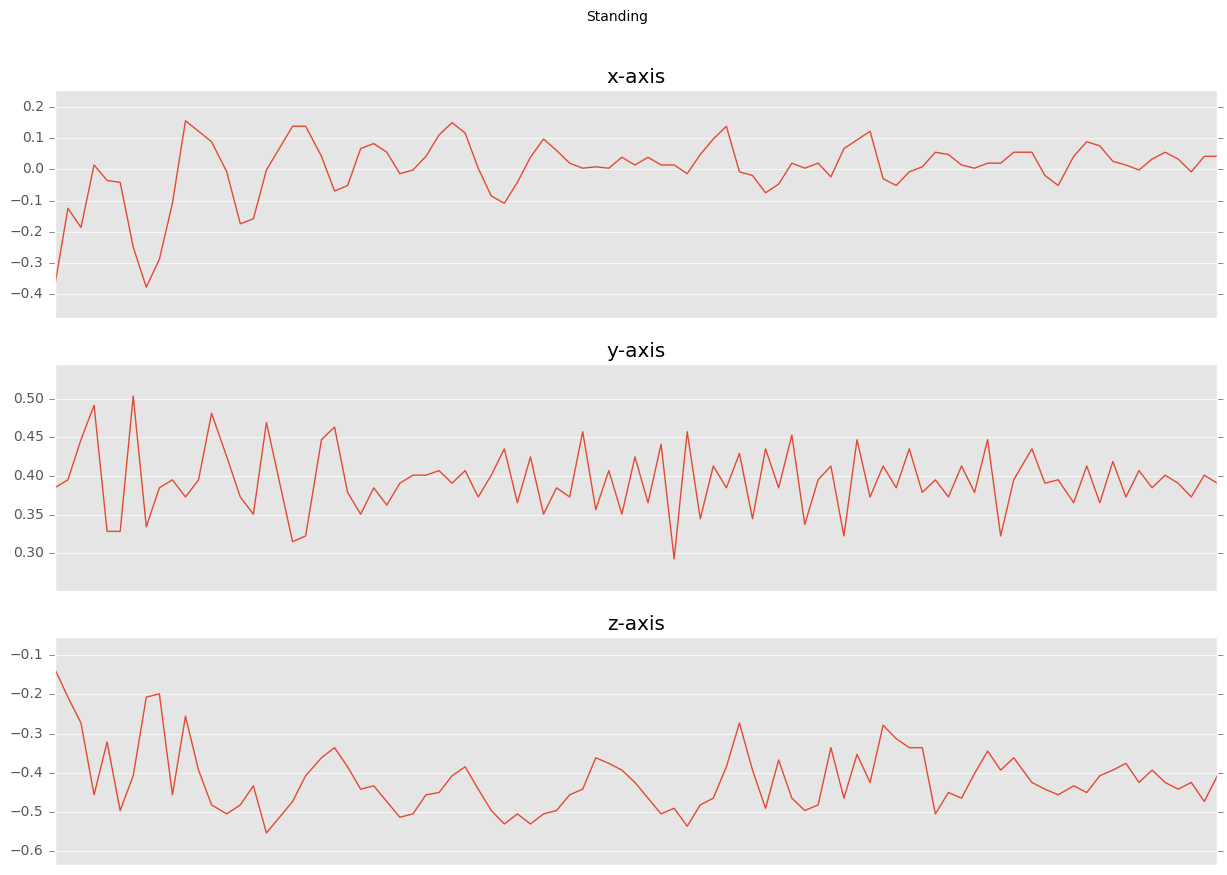

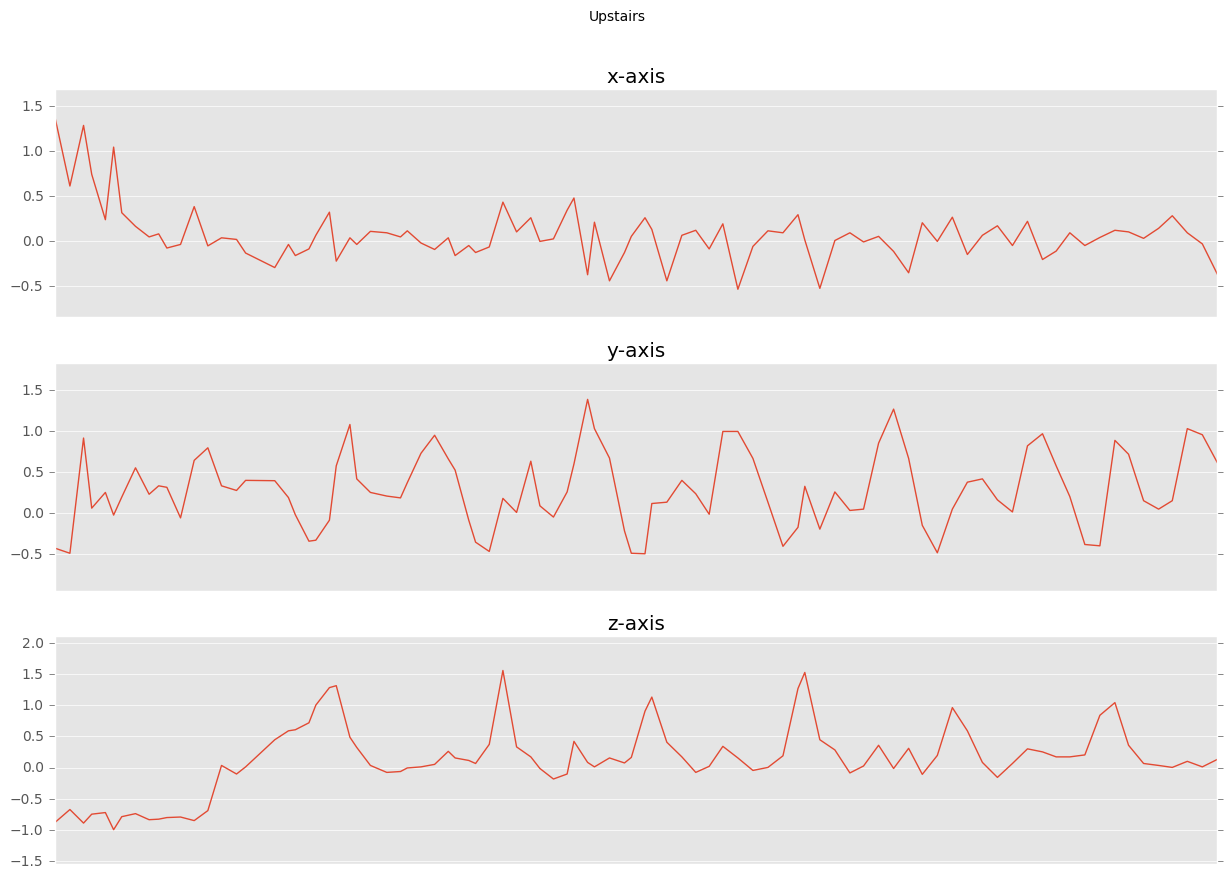

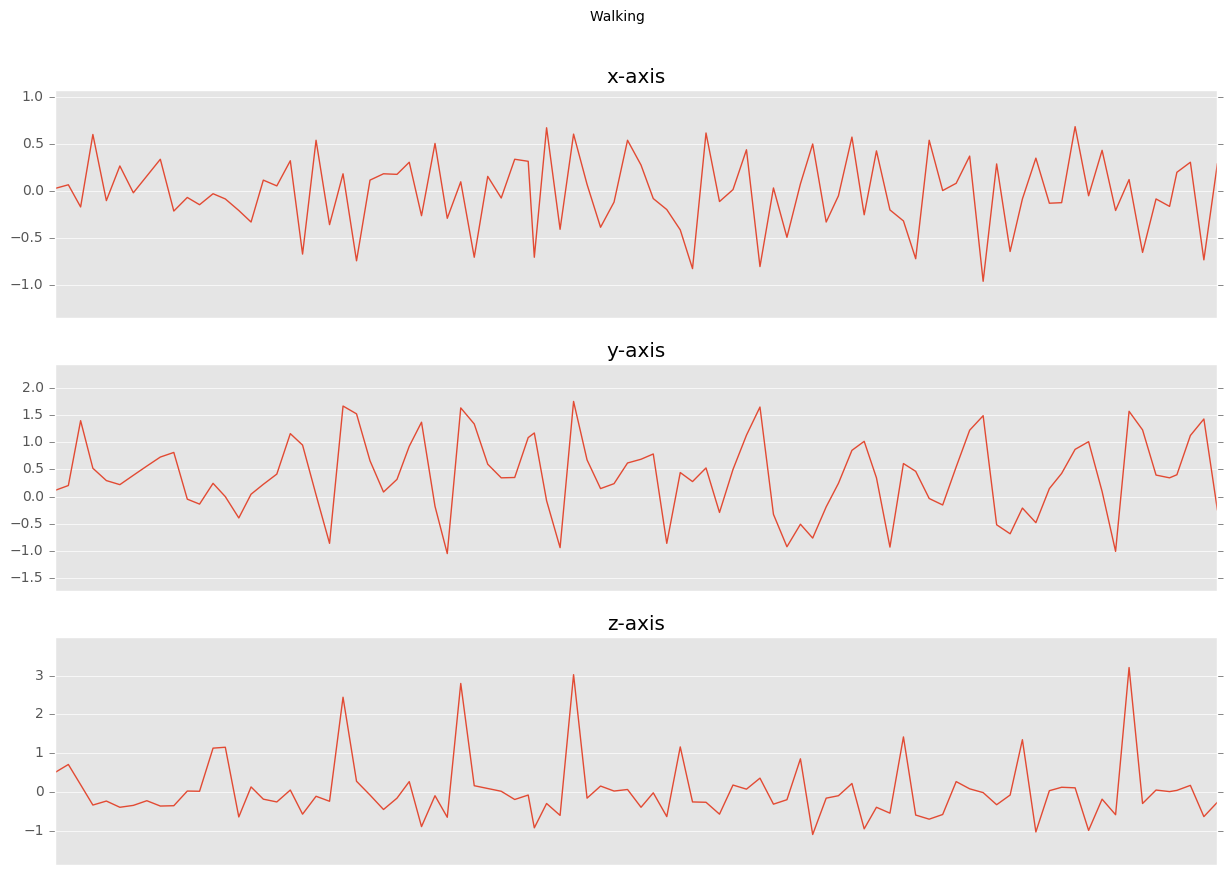

In [31]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:90]
    plot_activity(activity,subset)

In [32]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in tqdm(windows(data['timestamp'], window_size)):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [49]:
data = dataset.iloc[:9000,:]

In [50]:
data.isnull().sum()

user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64

In [52]:
segments, labels = segment_signal(data)

129it [00:00, 490.99it/s]


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [38]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')